In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style
import sklearn
from sklearn.model_selection import KFold

MODEL_NAME = f"model-{time.asctime()}" 


In [2]:
BATCH_SIZE = 75
EPOCHS = 30
PATH = "model/model.pt"
IMG_SIZE = 50

In [3]:
REBUILD_DATA =False  # set to true to one once, then back to false unless you want to change something in your

In [4]:

# preparing data.
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "D:/projects/Neural_Networks/coursera_v2/PetImages/Dog"
    DOGS = "D:/projects/Neural_Networks/coursera_v2/PetImages/Cat"
    TESTING = "D:/projects/Neural_Networks/coursera_v2/PetImages/TESTING"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" or "jpeg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[
                            self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot
                        # print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        # print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:', dogsvcats.catcount)
        print('Dogs:', dogsvcats.dogcount)


In [5]:
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
#neural network with dropout

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
#        self.bn1 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(32, 64, 5)
#        self.bn2 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.bn1 = nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.AlphaDropout(p=0.3)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

        '''>>> # With Learnable Parameters
        >>> m = nn.BatchNorm2d(100)
        >>> # Without Learnable Parameters
        >>> m = nn.BatchNorm2d(100, affine=False)
        >>> input = torch.randn(20, 100, 35, 45)
        >>> output = m(input)'''

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        x = self.dropout(x)
        return F.softmax(x, dim=1)

In [8]:
#creating model
net = Net().to(device)

In [9]:
#loading data
data = np.load("training_data.npy", allow_pickle=True)
print(len(data))

24998


In [10]:
X = torch.Tensor([i[0] for i in data]).view(-1, 50, 50) 
X = X / 255.0 # scaling the data

print(X.size())
y = torch.Tensor([i[1] for i in data])

torch.Size([24998, 50, 50])


In [11]:
"""dataset = TensorDataset(X , y)
trainloader = DataLoader(dataset , batch_size = 16, shuffle=True)"""

In [12]:
VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
print(val_size)

#creating data and train sets.

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

print(len(X)/2499)

2499
22499
2499
10.003201280512204


In [13]:
from torch.utils.data import DataLoader , TensorDataset, SubsetRandomSampler

sampler = SubsetRandomSampler(list(range(int(len(train_X)))))

test_sampler = SubsetRandomSampler(list(range(int(len(test_X)))))

t_dataset = TensorDataset(train_X , train_y)
trainloader = DataLoader(t_dataset , batch_size = BATCH_SIZE, sampler= sampler)

v_dataset = TensorDataset(test_X, test_y)
testloader = DataLoader(v_dataset, batch_size = BATCH_SIZE, sampler= test_sampler)


In [14]:
"""train_sampler = SubsetRandomSampler(list(range(int(len(data)*0.8+1))))
valid_sampler = SubsetRandomSampler(list(range(int(len(data)*0.2))))

print(int(len(data)*0.8), int(len(data)*0.2), int(len(data)*0.2)+int(len(data)*0.8))"""

In [15]:
#help(torch.utils.data.TensorDataset)
"""
print(next(iter(testloader)), "......",
next(iter(testloader)))"""

In [16]:
"""    SAMPLER = torch.utils.data.SequentialSampler(X[-val_size:])
    valid_loader = torch.utils.data.DataLoader(X[-val_size:], batch_size = BATCH_SIZE, shuffle= True)
    
    for i in range(2):
        print(next(iter(valid_loader)))"""

In [17]:
def Train(net):
    with open("model_new.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):   
                dt = next(iter(trainloader))
                batch_X = dt[0].view(-1, 1, 50, 50)
                batch_y = dt[1]
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                
                acc, loss = fwd_pass(batch_X, batch_y , train_=True)
                
                if i % 50 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(
                        f"{MODEL_NAME},{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},"
                        f"{round(float(val_acc), 2)},{round(float(val_loss), 4)},{epoch}\n")
                    torch.save({
                        'dropout cnn model': MODEL_NAME,
                        'epoch': epoch,
                        'model_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()
                    }, PATH)


In [18]:
def test(size=32):
    test_dt = next(iter(testloader))
    X, y = test_dt[0].view(-1, 1, 50, 50), test_dt[1]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss

In [19]:

def create_acc_loss_graph(model_name):
    contents = open("model_new.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

    fig = plt.figure()

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

In [20]:
#parameters
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [21]:
def fwd_pass(X, y, train_=False):
    if train_:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True) / len(matches)
    loss = loss_function(outputs, y)

    if train_:
        loss.backward()
        optimizer.step()

    return acc, loss

In [22]:
style.use("ggplot")
MODEL_NAME = f"model-{time.asctime()}" 
print(MODEL_NAME)


model-Mon Jul 20 00:34:49 2020


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:34<00:00,  8.77it/s]


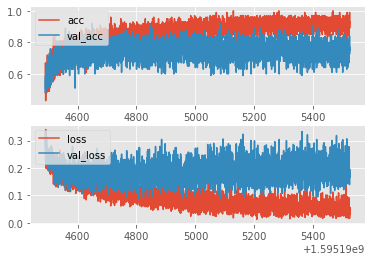

In [23]:
Train(net)
create_acc_loss_graph(MODEL_NAME)

In [24]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([32, 1, 5, 5])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 5, 5])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 5, 5])
conv3.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
bn1.weight 	 torch.Size([512])
bn1.bias 	 torch.Size([512])
bn1.running_mean 	 torch.Size([512])
bn1.running_var 	 torch.Size([512])
bn1.num_batches_tracked 	 torch.Size([])
fc2.weight 	 torch.Size([2, 512])
fc2.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {2709589536488: {'step': 9000, 'exp_avg': tensor([[[[ 7.1710e-03,  8.7106e-03,  6.8312e-03,  6.6347e-03,  7.8240e-03],
          [ 5.6354e-03,  7.6146e-03,  6.7746e-03,  6.3800e-03,  3.9094e-03],
          [ 1.0074e-02,  9.6799e-03,  5.5305e-03,  7.6968e-03,  4.5301e-03],
          [ 1.1684e-02,  8.4022e-03,  4.2664e-03,  3.2712e-03,  6.4225e-03],
          [ 1.1110e-02,  8.6093e-03,  4.4433e-03,  3.1389e-03,  4.7056e-03]]],




In [25]:
"""PATH = "model/model.pt"
torch.save({
            'net_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, PATH)"""

model = Net().to(device)
opt = optim.Adam(net.parameters(), lr=0.001)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['net_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in opt.state_dict():
    print(var_name, "\t", opt.state_dict()[var_name])

KeyError: 'net_state_dict'

In [ ]:
"""optimizerb = optim.Adam(net.parameters(), lr=0.001)
print("Optimizer's state_dict:")
for var_name in optimizerb.state_dict():
    print(var_name, "\t", optimizerb.state_dict()[var_name])"""

In [ ]:
"""from IPython.display import display
from PIL import Image

def load_image(path):
    img_PIL = Image.open(path)
    display(img_PIL)

 
# load an image and predict the class
def run_example():
    print(":)")
 
# entry point, run the example
run_example()

path = "samples/sample_image.jpg"
load_image(path)"""

In [ ]:
#help(Image.open)

In [ ]:
"""path = "D:/projects/Neural_Networks/coursera_v2/coursera/samples/sample_image.JPG"
print(os.path.exists(path))

img = cv2.imread(r"D:/projects/Neural_Networks/coursera_v2/coursera/samples/sample_image.JPG", cv2.IMREAD_GRAYSCALE )

#if img == None: # older numpy / py2
    # fail !!
#    print("fail!1")
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img, cmap='gray')"""

tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBac

tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBac

tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBac

tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBac

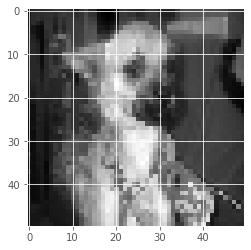

In [30]:
yhat = []
for i in range(500):
    fname = "D:/projects/Neural_Networks/coursera_v2/PetImages/dog/" + str(i)+ ".jpeg"
    #print(fname)
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    
    #if img == None: # older numpy / py2
    # fail !!
    #    print("fail!1")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    plt.imshow(img, cmap='gray')
    x = torch.Tensor([i for i in img]).view(-1, 50, 50)
    y= torch.Tensor([0,1]).to(device)
    test_x = x.view(-1, 1, 50, 50)
    test_x = test_x.to(device)
    net.eval()
    #with torch.no_grad():
    yhat.append(net(test_x))
    print(yhat[i])
    
matches = [torch.argmax(yhat[i]) == torch.argmax(y) for i in range(len(yhat))]
acc = matches.count(True) / len(matches)
print(acc)

In [27]:
sample = test_X[0:0 + BATCH_SIZE].view(-1, 1, 50, 50)
sample = sample.to(device)
#with torch.no_grad():
output = net(sample)
acc_, loss_ = fwd_pass(sample,test_y[0:0 + BATCH_SIZE].to(device) )
print(acc_, loss_)
print(output, "=?", test_y[0:0 + BATCH_SIZE]) 

0.6666666666666666 tensor(0.3000, device='cuda:0', grad_fn=<MseLossBackward>)
tensor([[9.7417e-07, 1.0000e+00],
        [1.9445e-13, 1.0000e+00],
        [9.5397e-01, 4.6034e-02],
        [5.0642e-01, 4.9358e-01],
        [3.1123e-05, 9.9997e-01],
        [1.0000e+00, 4.2428e-12],
        [1.0000e+00, 1.1426e-14],
        [9.9916e-01, 8.4114e-04],
        [7.9942e-01, 2.0058e-01],
        [3.9406e-05, 9.9996e-01],
        [9.9997e-01, 2.5670e-05],
        [1.0000e+00, 7.1245e-12],
        [1.8775e-08, 1.0000e+00],
        [9.8200e-01, 1.7996e-02],
        [1.3294e-06, 1.0000e+00],
        [9.6531e-01, 3.4689e-02],
        [3.2303e-02, 9.6770e-01],
        [9.6624e-01, 3.3755e-02],
        [1.0000e+00, 1.0427e-09],
        [1.0000e+00, 9.9898e-19],
        [2.2518e-18, 1.0000e+00],
        [3.2220e-04, 9.9968e-01],
        [1.0000e+00, 1.4105e-12],
        [1.0000e+00, 2.4394e-07],
        [9.6421e-01, 3.5792e-02],
        [1.0000e+00, 7.6721e-11],
        [9.9997e-01, 2.8967e-05],
    